# QRT Challenge 2025
## Overall Survival Prediction for Patients Diagnosed with Myeloid Leukemia

*March 2025 - Gaëtan Ecrepont*

## 1. Import libraries

In [5]:
from xgboost import XGBRegressor
from xgboost import plot_importance
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sksurv.metrics import concordance_index_ipcw

import data
import examine

sns.set_theme() # pretty plots

## 2. Load data

In [6]:
X_train, _ = data.build_X("train") # don't impute missing values for now (we will do it during cross-validation)
X_train_imputed, _ = data.build_X("train", force_impute=True) # impute missing values (useful for final fit of the model)
y_train, y_xgb_train = data.load_y_train()
SEED = 42

Loading train data...
Loading train data...


## 3. Cross-validate & fit model

In [7]:
xgb = XGBRegressor( # the one which scored 0.7268 (submission0)
    objective="survival:cox",
    eval_metric="cox-nloglik",
    n_estimators=369,
    max_depth=3,
    learning_rate=0.0197,
    subsample=0.432,
    colsample_bytree=0.661,
    random_state=SEED,
)

for seed in [0,1,2]: # CV on several seeds just to make sure it's not luck
    print(f"Seed {seed}")
    mean_c_index_train, mean_c_index_test = examine.cross_validate(xgb, X_train, y_train, y_xgb_train, n_splits=5, seed=seed)
    print(f"Mean c-index train: {mean_c_index_train:.4f}")
    print(f"Mean c-index test: {mean_c_index_test:.4f}")
    print()

# Fit the model on the whole training set
xgb.fit(X_train_imputed, y_xgb_train)

Seed 0
Mean c-index train: 0.7735
Mean c-index test: 0.7239

Seed 1
Mean c-index train: 0.7732
Mean c-index test: 0.7224

Seed 2
Mean c-index train: 0.7733
Mean c-index test: 0.7241



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.661, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='cox-nloglik',
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.0197, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=369,
             n_jobs=None, num_parallel_tree=None, objective='survival:cox', ...)

## 4. Feature importance

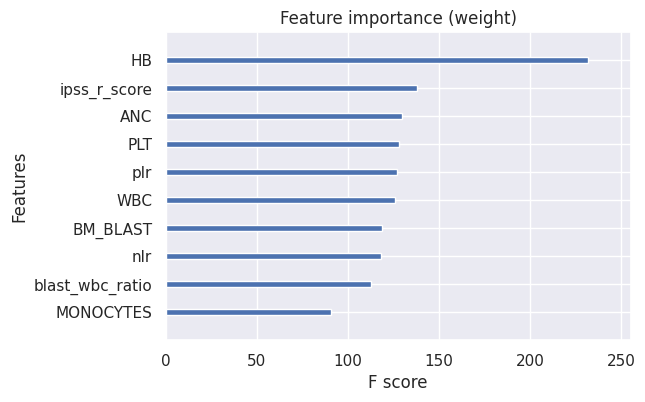

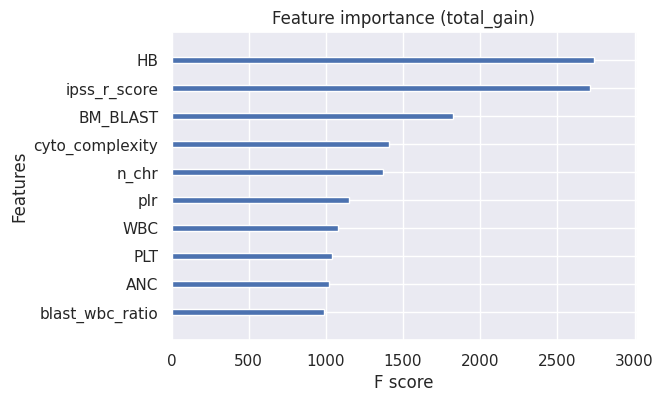

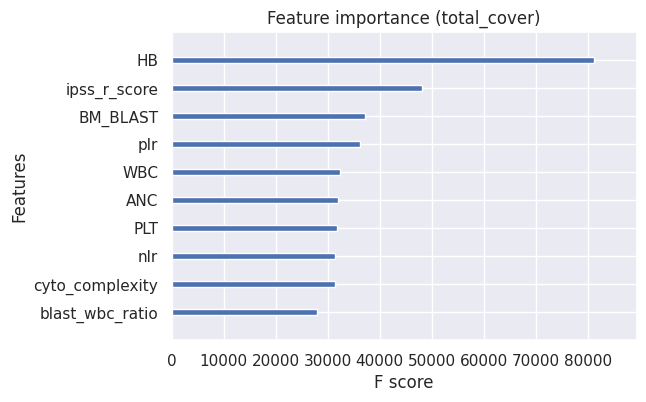

In [8]:
for importance_type in ['weight', 'total_gain', 'total_cover']:
    fig, ax = plt.subplots(figsize=(6, 4), dpi=100)
    plot_importance(xgb, importance_type=importance_type, max_num_features=10, show_values=False, ax=ax)
    plt.title(f"Feature importance ({importance_type})")
    # plt.savefig(f"img/feature_importance_xgb_{importance_type}.png", bbox_inches='tight')

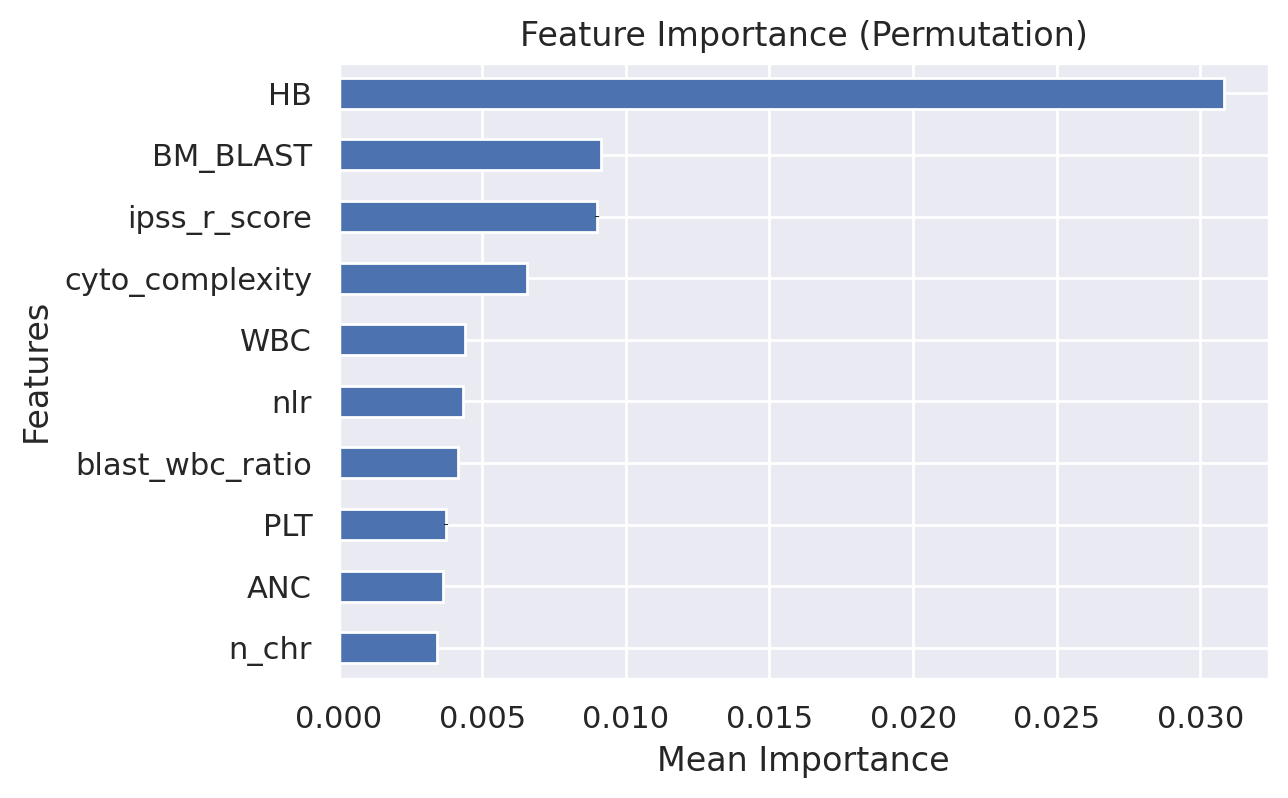

In [9]:
# permutation importance (using custom IPCW as metric)
examine.plot_PI_xgb(xgb, X_train_imputed, y_train, y_xgb_train, n_repeats=10, random_state=SEED, top_k=10)

## 5. Examining the output

In [10]:
X1, X2, y1, y2, y_xgb1, y_xgb2 = train_test_split(X_train, y_train, y_xgb_train, test_size=0.3, random_state=SEED) # train-test split

xgb.fit(X1, y_xgb1)
risk_pred = xgb.predict(X2)
log_risk_pred = np.log(risk_pred)
ipcw = concordance_index_ipcw(y1, y2, risk_pred, tau=7)[0]

dead_patients = y2['OS_STATUS'] == 1
plt.figure(figsize=(6, 6), dpi=200)
x = np.log1p(y2['OS_YEARS'])
y = log_risk_pred
plt.scatter(y[dead_patients], x[dead_patients], color='red', label='Dead patients')
plt.scatter(y[~dead_patients], x[~dead_patients], color='blue', label='Censored patients')
plt.ylabel("log(OS_YEARS)")
plt.xlabel("log(risk score)")
plt.title("Predicted risk vs. OS_YEARS")
plt.legend()
plt.savefig("img/risk_score_vs_OS_YEARS.png", bbox_inches='tight')
plt.close()

## 6. Creating a submission file

In [11]:
model = xgb
X_test, patient_id = data.build_X("test")
X_test = X_test[X_train.columns] # reorder columns to match training set

print(f"Predicting with {model .__class__.__name__}...")
y_pred = model.predict(X_test)
y_pred = pd.Series(y_pred, index=patient_id, name="risk_score").astype("float64")
# y_pred.to_csv("submissions/my_submission.csv")

Loading test data...
Column 14 not found in the test set. Filling with 0.
Column 2KB_upstream_variant not found in the test set. Filling with 0.
Column 3_prime_UTR_variant not found in the test set. Filling with 0.
Column complex_change_in_transcript not found in the test set. Filling with 0.
Column inframe_variant not found in the test set. Filling with 0.
Column initiator_codon_change not found in the test set. Filling with 0.
Column splice_site_variant not found in the test set. Filling with 0.
Column stop_retained_variant not found in the test set. Filling with 0.
Column synonymous_codon not found in the test set. Filling with 0.
Predicting with XGBRegressor...
